# Domain Adaptation

In [ ]:
from dataset import (
    build_hsi_testloader,
    build_hsi_dataloader,
    HSIDataset,
    build_FIVES_random_crops_dataloaders,
)
from torch.utils.data import DataLoader

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=1,
        load_from_path='data/FIVES_random_crops_threshold01'
    )
)

window = (500, 600)
target_augmented= True
trainloader_target = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
    augmented=target_augmented,
)[0]

testloader_target = build_hsi_testloader(
    batch_size=1,
    window=window,
)

print(len(trainloader_target.dataset), len(testloader_target.dataset))

Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
62 5


## Evaluation of Model without Domain Adaptation on Target Testset

### Transfer Learning

In [3]:
from segmentation_util import evaluate_model, build_segmentation_model
import torch
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = build_segmentation_model('resnet50', 'Unet', device, in_channels=1)

evaluate_model(
    model, testloader_target, device, with_wandb=False
)

Precision: nan, Recall: 0.0239, F1 Score: 0.0410, Dice Score: 0.0410, Accuracy: 0.7850


(tensor(nan, device='cuda:3'),
 tensor(0.0239, device='cuda:3'),
 tensor(0.0410, device='cuda:3'),
 tensor(0.7850, device='cuda:3'),
 tensor(0.0410, device='cuda:3'))

### Ensemble Model

In [ ]:
from HSI_Net import SegmentationModelWithWindowing
from segmentation_util import build_segmentation_model, evaluate_model
from ensemble_model import EnsembleModelAverage
import segmentation_models_pytorch as smp
import torch

path = "./data/helicoid_with_labels"
testset = HSIDataset(path, with_gt=True)
testset.crop_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)

encoder = 'timm-regnetx_320'
architecture = 'Linknet'
device = ('cuda:5' if torch.cuda.is_available() else 'cpu')

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window1))
model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window2))
model_windowing_600to700 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window3))
model_windowing_700to800 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window4))
model_windowing_800to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window5))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window6))
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window_full))

model = EnsembleModelAverage([model_windowing_400to500, model_with_windowing_500to600, model_windowing_600to700, model_windowing_700to800, model_windowing_900to1000, model_window_full])
evaluate_model(model, testloader_target, device, with_wandb=False)

Precision: 0.5368, Recall: 0.2351, F1 Score: 0.3072, Dice Score: 0.3072, Accuracy: 0.8104


(tensor(0.5368, device='cuda:3'),
 tensor(0.2351, device='cuda:3'),
 tensor(0.3072, device='cuda:3'),
 tensor(0.8104, device='cuda:3'),
 tensor(0.3072, device='cuda:3'))

## Domain Adaptation Approaches:
### GRL domain adaptation

In [ ]:
import matplotlib.pyplot as plt
import torch
from domain_adaptation_training import model_pipeline

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.001
loss = "BCE"
epochs = 10
in_channels = 1
hidden_dim = 256

config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}-pretrained-random_crops-bloodvessel_ratio01".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "hidden_dim": hidden_dim,
    "epochs": epochs,
    "loss": loss,
    "in_channels": in_channels,
    "pretrained": './models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth'
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target,
    testloader_target,
    config,
    project="domain-adaptation",
    device=device,
    batch_print=10,
    evaluate=True,
    with_overlays=True,
)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descript

Epoch 1, Batch 10/34, Total Loss: 1.8441, Segmentation Loss: 0.4249, Domain Loss Source: 0.6113, Domain Loss Target: 0.6371
Epoch 1, Batch 20/34, Total Loss: 1.7106, Segmentation Loss: 0.3447, Domain Loss Source: 0.5976, Domain Loss Target: 0.9083
Epoch 1, Batch 30/34, Total Loss: 1.7214, Segmentation Loss: 0.3221, Domain Loss Source: 0.7402, Domain Loss Target: 0.8175
Epoch 1, Train Loss: 1.7574
Evaluating model performance on source data
Precision: 0.9107, Recall: 0.3290, F1 Score: 0.4825, Dice Score: 0.4825, Accuracy: 0.8770
Evaluating model performance on target data
Precision: nan, Recall: 0.0748, F1 Score: 0.1181, Dice Score: 0.1181, Accuracy: 0.7753
Epoch 1, Validation Loss Source: 0.2613, Validation Loss Target: 1.4982
Epoch 2, Batch 10/34, Total Loss: 1.8595, Segmentation Loss: 0.2791, Domain Loss Source: 0.7408, Domain Loss Target: 0.9152
Epoch 2, Batch 20/34, Total Loss: 1.7727, Segmentation Loss: 0.2733, Domain Loss Source: 0.6027, Domain Loss Target: 0.9855
Epoch 2, Batch 

### FADA:

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10/34, Total Loss: 1.0997, Segmentation Loss: 0.4064, Domain Loss Source: 0.3222, Domain Loss Target: 0.2844, Adversarial Loss Target: 0.0007
Epoch 1, Batch 20/34, Total Loss: 0.9839, Segmentation Loss: 0.4065, Domain Loss Source: 0.2877, Domain Loss Target: 0.2826, Adversarial Loss Target: 0.0007
Epoch 1, Batch 30/34, Total Loss: 0.8567, Segmentation Loss: 0.3302, Domain Loss Source: 0.1917, Domain Loss Target: 0.2431, Adversarial Loss Target: 0.0010
Epoch 1, Train Loss: 5.0979


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.8949, Recall: 0.4479, F1 Score: 0.5957, Dice Score: 0.5957, Accuracy: 0.8942
Evaluating model performance on target data
Precision: 0.3215, Recall: 0.2015, F1 Score: 0.2431, Dice Score: 0.2431, Accuracy: 0.7767
Epoch 1, Validation Loss Source: 0.2260, Validation Loss Target: 0.7262
Epoch 2, Batch 10/34, Total Loss: 0.8060, Segmentation Loss: 0.2464, Domain Loss Source: 0.3060, Domain Loss Target: 0.1168, Adversarial Loss Target: 0.0015
Epoch 2, Batch 20/34, Total Loss: 0.7732, Segmentation Loss: 0.2719, Domain Loss Source: 0.4223, Domain Loss Target: 0.1232, Adversarial Loss Target: 0.0016
Epoch 2, Batch 30/34, Total Loss: 0.7225, Segmentation Loss: 0.2294, Domain Loss Source: 0.1958, Domain Loss Target: 0.1857, Adversarial Loss Target: 0.0013
Epoch 2, Train Loss: 4.0318
Evaluating model performance on source data
Precision: 0.8939, Recall: 0.5461, F1 Score: 0.6763, Dice Score: 0.6763, Accuracy: 0.9093
Evaluating model performanc

dice_score/source,▁▆▇▇▇█▇▇██
dice_score/target,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,███▆▂▁▁▁▂▃
precision/target,▁▆▇█▇▇▇▇▇▇
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▅▄▃▂▃▂▂▁▁


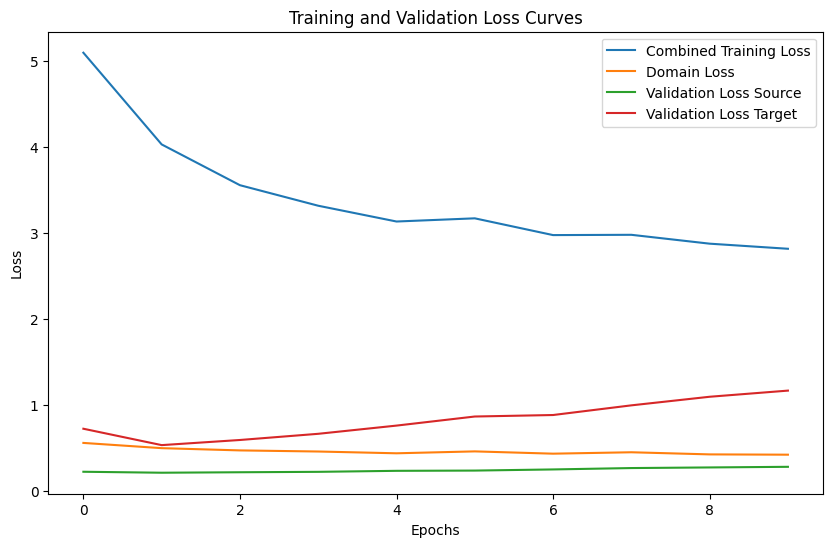

In [2]:
import matplotlib.pyplot as plt
from FADA.train_FADA_unsupervised import model_pipeline
import torch

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
epochs = 10
loss = "BCE"
in_channels = 1
ndf = 512
learning_rate_fea = 0.001
learning_rate_cls = 0.001
learning_rate_dis = 0.0001

config = {
    "model": "FADA-{architecture}-{encoder}-window_{window[0]}-{window[1]}_pretrained-augmented_target-random_crops_bloodvessel_ratio01-unsupervised".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth",
    "target_augmented": target_augmented,
}


model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_target,
        testloader_target,
        config,
        project="domain-adaptation",
        device=device,
        batch_print=10,
        evaluate=True,
        with_overlays=True,
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### Supervised Domain Adapatation

#### GRL

In [ ]:
from torch.utils.data import DataLoader, Subset
import torch
from supervised_domain_adaptation import model_pipeline

trainloader_target_labeled = DataLoader(
    Subset(testset, [0]),
    batch_size=1,
    shuffle=True,
)
testloader_target = DataLoader(
    Subset(testset, [1, 2, 3, 4]), batch_size=1, shuffle=False
)

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.001
loss = "Dice"
epochs = 10
in_channels = 1
hidden_dim = 256

config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}-pretrained-random_crops-bloodvessel_ratio01-supervised".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "hidden_dim": hidden_dim,
    "epochs": epochs,
    "loss": loss,
    "in_channels": in_channels,
    "pretrained": './models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth',
    "supervised": True,
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target_labeled,
    trainloader_target,
    testloader_target,
    config,
    project="supervised-domain-adaptation",
    device=device,
    batch_print=1,
    evaluate=True,
    with_overlays=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 1/34, Total Loss: 2.1479, Segmentation Loss: 0.7283, Domain Loss Source: 0.7582, Domain Loss Target: 0.6614
Epoch 1, Batch 2/34, Total Loss: 30.4464, Segmentation Loss: 0.6874, Domain Loss Source: 0.0000, Domain Loss Target: 29.7590
Epoch 1, Batch 3/34, Total Loss: 45.6899, Segmentation Loss: 0.6732, Domain Loss Source: 43.6820, Domain Loss Target: 1.3348
Epoch 1, Batch 4/34, Total Loss: 60.7336, Segmentation Loss: 0.6997, Domain Loss Source: 58.5175, Domain Loss Target: 1.5164
Epoch 1, Batch 5/34, Total Loss: 19.6700, Segmentation Loss: 0.6691, Domain Loss Source: 15.5772, Domain Loss Target: 3.4236
Epoch 1, Batch 6/34, Total Loss: 23.4743, Segmentation Loss: 0.7398, Domain Loss Source: 16.1773, Domain Loss Target: 6.5572
Epoch 1, Batch 7/34, Total Loss: 39.3069, Segmentation Loss: 0.6454, Domain Loss Source: 0.7192, Domain Loss Target: 37.9422


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Batch 8/34, Total Loss: 31.2116, Segmentation Loss: 0.7010, Domain Loss Source: 11.5278, Domain Loss Target: 18.9828
Epoch 1, Batch 9/34, Total Loss: 6.9516, Segmentation Loss: 0.6254, Domain Loss Source: 5.3976, Domain Loss Target: 0.9286
Epoch 1, Batch 10/34, Total Loss: 3.5846, Segmentation Loss: 0.6483, Domain Loss Source: 0.1458, Domain Loss Target: 2.7905
Epoch 1, Batch 11/34, Total Loss: 10.3006, Segmentation Loss: 0.6348, Domain Loss Source: 2.2692, Domain Loss Target: 7.3966
Epoch 1, Batch 12/34, Total Loss: 9.2024, Segmentation Loss: 0.6809, Domain Loss Source: 1.9968, Domain Loss Target: 6.5247
Epoch 1, Batch 13/34, Total Loss: 4.0135, Segmentation Loss: 0.6346, Domain Loss Source: 3.1238, Domain Loss Target: 0.2550
Epoch 1, Batch 14/34, Total Loss: 19.5268, Segmentation Loss: 0.6613, Domain Loss Source: 6.5280, Domain Loss Target: 12.3374
Epoch 1, Batch 15/34, Total Loss: 2.5017, Segmentation Loss: 0.6154, Domain Loss Source: 1.8577, Domain Loss Target: 0.0286
Epoc

#### FADA

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10/34, Total Loss: 1.0578, Segmentation Loss: 0.4373, Domain Loss Source: 0.3387, Domain Loss Target: 0.2318, Adversarial Loss Target: 0.0009
Epoch 1, Batch 20/34, Total Loss: 0.9842, Segmentation Loss: 0.3694, Domain Loss Source: 0.3450, Domain Loss Target: 0.2909, Adversarial Loss Target: 0.0012
Epoch 1, Batch 30/34, Total Loss: 0.8321, Segmentation Loss: 0.3126, Domain Loss Source: 0.2059, Domain Loss Target: 0.2563, Adversarial Loss Target: 0.0010
Epoch 1, Train Loss: 4.9357


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.9679, Recall: 0.2987, F1 Score: 0.4549, Dice Score: 0.4549, Accuracy: 0.8754
Evaluating model performance on target data
Precision: nan, Recall: 0.1847, F1 Score: 0.2401, Dice Score: 0.2401, Accuracy: 0.7989
Epoch 1, Validation Loss Source: 0.2642, Validation Loss Target: 0.6929
Epoch 2, Batch 10/34, Total Loss: 0.7133, Segmentation Loss: 0.2836, Domain Loss Source: 0.2742, Domain Loss Target: 0.1458, Adversarial Loss Target: 0.0018
Epoch 2, Batch 20/34, Total Loss: 0.7254, Segmentation Loss: 0.2543, Domain Loss Source: 0.2818, Domain Loss Target: 0.1544, Adversarial Loss Target: 0.0020
Epoch 2, Batch 30/34, Total Loss: 0.6715, Segmentation Loss: 0.2273, Domain Loss Source: 0.3369, Domain Loss Target: 0.1476, Adversarial Loss Target: 0.0018
Epoch 2, Train Loss: 3.5858
Evaluating model performance on source data
Precision: 0.9597, Recall: 0.4010, F1 Score: 0.5633, Dice Score: 0.5633, Accuracy: 0.8920
Evaluating model performance o

dice_score/source,▁▅▇▇█████▇
dice_score/target,▁▃▇███████
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,█▇▅▄▃▂▂▁▂▂
precision/target,▁██▇▇█▇▇█
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▃▅▄▅▃▃▄▃▁


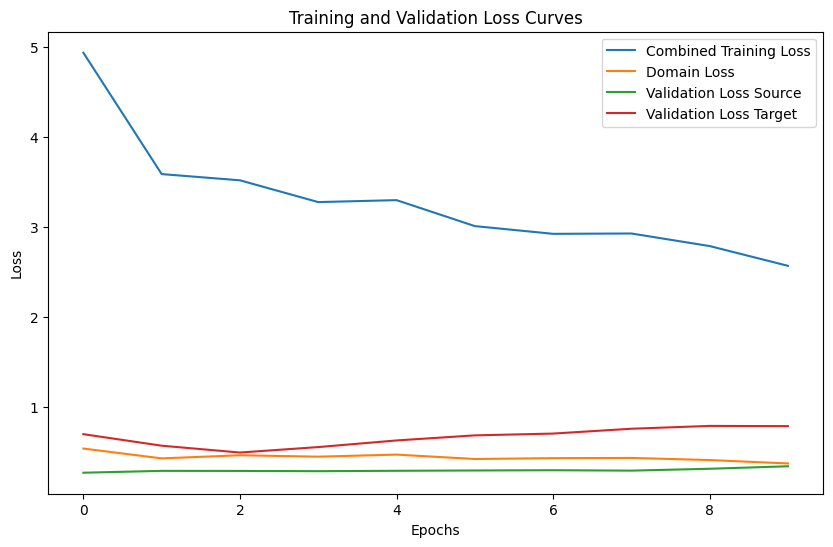

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from FADA.train_FADA_supervised import model_pipeline

train_indices = [0]
trainloader_target_labeled = DataLoader(
    Subset(testset, train_indices),
    batch_size=1,
    shuffle=True,
)
testloader_target = DataLoader(
    Subset(testset, list({0, 1, 2, 3, 4} - set(train_indices))),
    batch_size=1,
    shuffle=False,
)

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
epochs = 10
loss = "BCE"
in_channels = 1
ndf = 512
learning_rate_fea = 0.001
learning_rate_cls = 0.001
learning_rate_dis = 0.0001

config = {
    "model": "FADA-{architecture}-{encoder}-window_{window[0]}-{window[1]}_pretrained-augmented_target-random_crops_bloodvessel_ratio01".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth",
    "target_augmented": target_augmented,
    "train_indices": train_indices,
}


model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_target_labeled,
        trainloader_target,
        testloader_target,
        config,
        project="supervised-domain-adaptation",
        device=device,
        batch_print=10,
        evaluate=True,
        with_overlays=True,
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### Gaussian Autoencoder

#### Training

In [ ]:
from dataset import build_hsi_dataloader, HSIDataset, build_hsi_testloader
from dimensionality_reduction.autoencoder import (
    GaussianAutoEncoder,
    model_pipeline_autoencoder,
)
import torch
from torch.utils.data import DataLoader

trainloader_hsi = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    exclude_labeled_data=False,
    augmented=True,
)[0]

testloader_hsi = build_hsi_testloader()

lr = 0.001
gaussian = GaussianAutoEncoder()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gaussian.parameters(), lr=lr)

config = {
    "model": "gaussianEncoder",
    "optimizer": "Adam",
    "learning_rate": lr,
    "batch_size": trainloader_hsi.batch_size,
    "epochs": 10,
}

model_pipeline_autoencoder(
    gaussian,
    trainloader_hsi,
    testloader_hsi,
    criterion,
    optimizer,
    config,
    project="hsi-autoencoder",
    device=device,
    model_name="gaussianEncoder",
    batch_print=5,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 5, Loss: 5.0748
Epoch 1, Train Loss: 2.9661
Epoch 1, Validation Loss: 0.6495
Epoch 2, Batch 5, Loss: 0.2959
Epoch 2, Train Loss: 0.3313
Epoch 2, Validation Loss: 0.6330
Epoch 3, Batch 5, Loss: 0.3934
Epoch 3, Train Loss: 0.3272
Epoch 3, Validation Loss: 0.6167
Epoch 4, Batch 5, Loss: 0.3448
Epoch 4, Train Loss: 0.3157
Epoch 4, Validation Loss: 0.6012
Epoch 5, Batch 5, Loss: 62.2633
Epoch 5, Train Loss: 34.7334
Epoch 5, Validation Loss: 0.5877
Epoch 6, Batch 5, Loss: 0.2836
Epoch 6, Train Loss: 42.2215
Epoch 6, Validation Loss: 0.5758
Epoch 7, Batch 5, Loss: 0.2711
Epoch 7, Train Loss: 0.2924
Epoch 7, Validation Loss: 0.5641
Epoch 8, Batch 5, Loss: 58.6640
Epoch 8, Train Loss: 32.6919
Epoch 8, Validation Loss: 0.5527
Epoch 9, Batch 5, Loss: 0.2692
Epoch 9, Train Loss: 0.2791
Epoch 9, Validation Loss: 0.5430
Epoch 10, Batch 5, Loss: 0.2846
Epoch 10, Train Loss: 0.2717
Epoch 10, Validation Loss: 0.5346


epoch,▁▂▃▃▄▅▆▆▇█
train/loss,▁▁▁▁▇█▁▆▁▁
validation/loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train/loss,0.27167
validation/loss,0.53465


(GaussianAutoEncoder(
   (encoder): GaussianChannelReduction()
   (decoder): Sequential(
     (0): Conv2d(3, 826, kernel_size=(1, 1), stride=(1, 1))
   )
 ),
 [2.966134073005782,
  0.33125145236651105,
  0.32722288535700905,
  0.3156745748387443,
  34.73344802028603,
  42.221503184901344,
  0.2923885054058499,
  32.69190951850679,
  0.2790806061691708,
  0.27167491614818573],
 [0.6494681775569916,
  0.6330470591783524,
  0.6166658580303193,
  0.6012413054704666,
  0.587684890627861,
  0.5758306831121445,
  0.5641373127698899,
  0.552744397521019,
  0.5430200010538101,
  0.5346450716257095])

#### Gaussian reduction + DA

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200


wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/serene-sweep-9.pth
Using Gaussian Channel Reduction


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 5/34, Total Loss: 1.1699, Segmentation Loss: 0.3311, Domain Loss Source: 0.4397, Domain Loss Target: 0.2116, Adversarial Loss Target: 0.0009
Epoch 1, Batch 10/34, Total Loss: 0.9620, Segmentation Loss: 0.2209, Domain Loss Source: 0.4229, Domain Loss Target: 0.2228, Adversarial Loss Target: 0.0009
Epoch 1, Batch 15/34, Total Loss: 0.9181, Segmentation Loss: 0.3021, Domain Loss Source: 0.2606, Domain Loss Target: 0.3590, Adversarial Loss Target: 0.0005
Epoch 1, Batch 20/34, Total Loss: 0.9204, Segmentation Loss: 0.3076, Domain Loss Source: 0.3039, Domain Loss Target: 0.3111, Adversarial Loss Target: 0.0006
Epoch 1, Batch 25/34, Total Loss: 0.8610, Segmentation Loss: 0.2523, Domain Loss Source: 0.3235, Domain Loss Target: 0.2869, Adversarial Loss Target: 0.0007
Epoch 1, Batch 30/34, Total Loss: 0.8575, Segmentation Loss: 0.2319, Domain Loss Source: 0.2785, Domain Loss Target: 0.2985, Adversarial Loss Target: 0.0007
Epoch 1, Train Loss: 2.7789


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.8994, Recall: 0.3781, F1 Score: 0.5296, Dice Score: 0.5296, Accuracy: 0.8838
Evaluating model performance on target data
Precision: 0.4693, Recall: 0.3541, F1 Score: 0.3976, Dice Score: 0.3976, Accuracy: 0.8082
Epoch 1, Validation Loss Source: 0.4600, Validation Loss Target: 0.7980
Epoch 2, Batch 5/34, Total Loss: 0.8199, Segmentation Loss: 0.2252, Domain Loss Source: 0.2959, Domain Loss Target: 0.2590, Adversarial Loss Target: 0.0008
Epoch 2, Batch 10/34, Total Loss: 0.8239, Segmentation Loss: 0.1674, Domain Loss Source: 0.3252, Domain Loss Target: 0.2990, Adversarial Loss Target: 0.0007
Epoch 2, Batch 15/34, Total Loss: 0.7801, Segmentation Loss: 0.2107, Domain Loss Source: 0.2524, Domain Loss Target: 0.3352, Adversarial Loss Target: 0.0006
Epoch 2, Batch 20/34, Total Loss: 0.7914, Segmentation Loss: 0.2326, Domain Loss Source: 0.3211, Domain Loss Target: 0.2519, Adversarial Loss Target: 0.0008
Epoch 2, Batch 25/34, Total Loss:

dice_score/source,▃▂▁▆▆▆▄█▇▇
dice_score/target,▂▁▁▆▆▆▅█▇█
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,▄██▆▆▅▅▁▃▃
precision/target,▁▂▁█▆▄▂▆▄▄
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▆▅▄▃▃▂▂▂▁


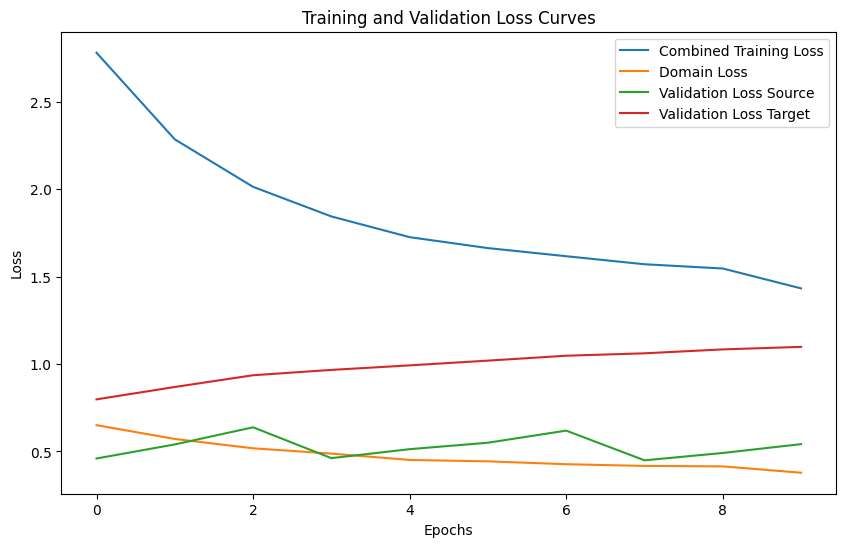

In [ ]:
import matplotlib.pyplot as plt
from FADA.train_FADA_unsupervised import model_pipeline
import torch
from dataset import build_hsi_dataloader, build_hsi_testloader, build_FIVES_random_crops_dataloaders

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=3,
        load_from_path='data/FIVES_random_crops_threshold01'
    )
)

trainloader_hsi = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    exclude_labeled_data=True,
    augmented=True,
)[0]

testloader_hsi = build_hsi_testloader()

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
epochs = 10
loss = "BCE"
in_channels = 3
ndf = 512
learning_rate_fea = 0.001
learning_rate_cls = 0.001
learning_rate_dis = 0.0001

config = {
    "model": "FADA-{architecture}-{encoder}-gaussian_reduction_pretrained-augmented_target-random_crops_bloodvessel_ratio01-unsupervised".format(
        architecture=architecture, encoder=encoder
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_hsi.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/serene-sweep-9.pth",
    "target_augmented": True,
    "gaussian": 'models/gaussianEncoder.pth',
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_hsi,
        testloader_hsi,
        config,
        project="domain-adaptation",
        device=device,
        batch_print=5,
        evaluate=True,
        with_overlays=True,
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()